In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    accuracy_score,
    matthews_corrcoef,
    roc_curve
)
from catboost import CatBoostClassifier, Pool
import matplotlib.pyplot as plt

## Base

In [3]:
data = pd.read_csv("clean.csv")

X = data.drop("Response", axis=1)
y = data["Response"]

# Get category featrues
cat_features = X.select_dtypes(include=["object", "category"]).columns.tolist()

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

# Create CatBoost Pool
train_pool = Pool(X_train, y_train, cat_features=cat_features)
test_pool = Pool(X_test, y_test, cat_features=cat_features)

model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    class_weights=[1, 3],
    eval_metric="AUC",
    early_stopping_rounds=50,
    verbose=100,
    random_seed=42
)

model.fit(train_pool, eval_set=test_pool)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

fpr_base, tpr_base, thresholds = roc_curve(y_test, y_prob)
auc_base = roc_auc_score(y_test, y_prob)
report = classification_report(y_test, y_pred)

print(f"AUC: {auc_base:.4f}")
print("Classification Report:")
print(report)

0:	test: 0.5680376	best: 0.5680376 (0)	total: 230ms	remaining: 1m 54s
100:	test: 0.6384542	best: 0.6387926 (98)	total: 4.49s	remaining: 17.7s
200:	test: 0.6439745	best: 0.6442538 (188)	total: 8.75s	remaining: 13s
300:	test: 0.6620680	best: 0.6620680 (300)	total: 13.2s	remaining: 8.75s
400:	test: 0.6647361	best: 0.6649192 (398)	total: 17.7s	remaining: 4.37s
499:	test: 0.6674577	best: 0.6676176 (495)	total: 22.1s	remaining: 0us

bestTest = 0.66761765
bestIteration = 495

Shrink model to first 496 iterations.
AUC: 0.6676
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.60      0.70      7735
           1       0.33      0.62      0.43      2442

    accuracy                           0.61     10177
   macro avg       0.58      0.61      0.57     10177
weighted avg       0.71      0.61      0.64     10177



### SMOTE

In [5]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder

data = pd.read_csv("clean.csv")
X = data.drop("Response", axis=1)
y = data["Response"]

# Get category features
cat_features = X.select_dtypes(include=["object", "category"]).columns.tolist()

# Label encode
label_encoders = {}
for col in cat_features:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

# Apply SMOTE
smote = SMOTE(random_state=42, k_neighbors=5)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f"Original shape: {X_train.shape}")
print(f"SMOTE shape: {X_train_resampled.shape}")

# Create CatBoost Pool
train_pool = Pool(X_train_resampled, y_train_resampled, cat_features=cat_features)
test_pool = Pool(X_test, y_test, cat_features=cat_features)

# Initial CatBoostClassifier
model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    eval_metric="AUC",
    early_stopping_rounds=50,
    verbose=100,
    random_seed=42
)

# Train model
model.fit(train_pool, eval_set=test_pool)

# Predict and Evaluate
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]
fpr_sm,tpr_sm,thresholds = roc_curve(y_test, y_prob)
auc_sm = roc_auc_score(y_test, y_prob)
report = classification_report(y_test, y_pred)

print(f"AUC: {auc_sm:.4f}")
print("Classification Report:",report)

Original shape: (40705, 14)
SMOTE shape: (61876, 14)
0:	test: 0.5513192	best: 0.5513192 (0)	total: 73ms	remaining: 36.4s
100:	test: 0.5635680	best: 0.5635680 (100)	total: 6.77s	remaining: 26.8s
200:	test: 0.5734767	best: 0.5734767 (200)	total: 15.5s	remaining: 23s
300:	test: 0.5856690	best: 0.5857133 (299)	total: 27.9s	remaining: 18.5s
400:	test: 0.5923648	best: 0.5924289 (399)	total: 40.2s	remaining: 9.92s
499:	test: 0.5972734	best: 0.5973118 (497)	total: 52.5s	remaining: 0us

bestTest = 0.5973117503
bestIteration = 497

Shrink model to first 498 iterations.
AUC: 0.5973
Classification Report:               precision    recall  f1-score   support

           0       0.78      0.85      0.81      7735
           1       0.32      0.22      0.27      2442

    accuracy                           0.70     10177
   macro avg       0.55      0.54      0.54     10177
weighted avg       0.67      0.70      0.68     10177



### Hyperparamter Tuning

In [4]:
from sklearn.model_selection import GridSearchCV
model = CatBoostClassifier(
    silent=True,
    random_state=42,
    eval_metric='AUC',
    cat_features=cat_features
)

param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [4, 6, 8],
    'iterations': [100, 300],
    'l2_leaf_reg': [1, 3, 5],
    'class_weights': [[1, 1], [1, 3]]
}
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    verbose=100,
    n_jobs= 1
)

grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]
fpr_tuned, tpr_tuned, thresholds = roc_curve(y_test, y_prob)
auc_tuned = roc_auc_score(y_test, y_prob)
report = classification_report(y_test, y_pred)

print(f"AUC: {auc_tuned:.4f}")
print("Classification Report:\n", report)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV 1/3; 1/108] START class_weights=[1, 1], depth=4, iterations=100, l2_leaf_reg=1, learning_rate=0.01
[CV 1/3; 1/108] END class_weights=[1, 1], depth=4, iterations=100, l2_leaf_reg=1, learning_rate=0.01;, score=0.590 total time=   2.0s
[CV 2/3; 1/108] START class_weights=[1, 1], depth=4, iterations=100, l2_leaf_reg=1, learning_rate=0.01
[CV 2/3; 1/108] END class_weights=[1, 1], depth=4, iterations=100, l2_leaf_reg=1, learning_rate=0.01;, score=0.590 total time=   1.8s
[CV 3/3; 1/108] START class_weights=[1, 1], depth=4, iterations=100, l2_leaf_reg=1, learning_rate=0.01
[CV 3/3; 1/108] END class_weights=[1, 1], depth=4, iterations=100, l2_leaf_reg=1, learning_rate=0.01;, score=0.590 total time=   1.8s
[CV 1/3; 2/108] START class_weights=[1, 1], depth=4, iterations=100, l2_leaf_reg=1, learning_rate=0.05
[CV 1/3; 2/108] END class_weights=[1, 1], depth=4, iterations=100, l2_leaf_reg=1, learning_rate=0.05;, score=0.618 total ti

#### Tuning plot

In [ ]:
# Tendency Plot
def plot_catboost_tuning_results(grid_search, top_n=15):
    results = grid_search.cv_results_

    param_combinations = []
    for params in results['params']:
        combo_str = '\n'.join([f'{k}: {v}' for k, v in params.items()])
        param_combinations.append(combo_str)

    sorted_indices = np.argsort(results['mean_test_score'])[::-1][:top_n]
    sorted_scores = results['mean_test_score'][sorted_indices]
    sorted_stds = results['std_test_score'][sorted_indices]
    sorted_params = [param_combinations[i] for i in sorted_indices]

    plt.figure(figsize=(16, 10))
    bars = plt.barh(range(len(sorted_scores)), sorted_scores,
                   xerr=sorted_stds, alpha=0.7, capsize=5,
                   color=['lightblue'] * (len(sorted_scores) - 1) + ['red'])

    plt.xlabel('AUC Score', fontsize=12)
    plt.ylabel('Parameter Combinations', fontsize=12)
    plt.title(f'Top {top_n} CatBoost Parameter Combinations Performance\n(Best AUC: {sorted_scores[0]:.4f} ± {sorted_stds[0]:.4f})',
              fontsize=14, pad=20)
    plt.gca().invert_yaxis()
    plt.grid(True, alpha=0.3, axis='x')

    plt.yticks(range(len(sorted_scores)), [f'Rank {i+1}' for i in range(len(sorted_scores))])

    for i, (score, std) in enumerate(zip(sorted_scores, sorted_stds)):
        plt.text(score + 0.005, i, f'{score:.4f} ± {std:.4f}',
                va='center', fontsize=9, fontweight='bold')

    plt.tight_layout()
    plt.show()

    return sorted_indices[0]

In [ ]:
# Parameter sensitivity
def plot_parameter_sensitivity(grid_search):
    results = grid_search.cv_results_
    param_names = list(param_grid.keys())

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()

    for i, param in enumerate(param_names):
        if i < len(axes):
            # Get mean performance
            param_values = []
            mean_scores = []
            std_scores = []

            for value in param_grid[param]:
                indices = [idx for idx, params in enumerate(results['params'])
                          if params[param] == value]
                if indices:
                    param_values.append(str(value))
                    mean_scores.append(np.mean([results['mean_test_score'][idx] for idx in indices]))
                    std_scores.append(np.mean([results['std_test_score'][idx] for idx in indices]))

            axes[i].errorbar(range(len(mean_scores)), mean_scores, yerr=std_scores,
                           fmt='o-', capsize=5, linewidth=2, markersize=8)
            axes[i].set_title(f'Sensitivity: {param}', fontsize=12)
            axes[i].set_xlabel('Parameter Value')
            axes[i].set_ylabel('Mean AUC')
            axes[i].set_xticks(range(len(param_values)))
            axes[i].set_xticklabels(param_values, rotation=45)
            axes[i].grid(True, alpha=0.3)

    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()

In [ ]:
def plot_learning_rate_impact(grid_search):
    results = grid_search.cv_results_

    lr_values = param_grid['learning_rate']
    lr_impact = {}

    for lr in lr_values:
        indices = [i for i, params in enumerate(results['params'])
                  if params['learning_rate'] == lr]
        if indices:
            mean_auc = np.mean([results['mean_test_score'][i] for i in indices])
            std_auc = np.mean([results['std_test_score'][i] for i in indices])
            lr_impact[lr] = (mean_auc, std_auc)
    plt.figure(figsize=(10, 6))
    lrs, means, stds = zip(*[(lr, mean, std) for lr, (mean, std) in lr_impact.items()])

    plt.errorbar(lrs, means, yerr=stds, fmt='o-', capsize=5,
                linewidth=2, markersize=8, color='green')
    plt.xlabel('Learning Rate', fontsize=12)
    plt.ylabel('Mean AUC Score', fontsize=12)
    plt.title('Impact of Learning Rate on Model Performance', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.xscale('log')
    plt.tight_layout()
    plt.show()

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV 1/3; 1/108] START class_weights=[1, 1], depth=4, iterations=100, l2_leaf_reg=1, learning_rate=0.01
[CV 1/3; 1/108] END class_weights=[1, 1], depth=4, iterations=100, l2_leaf_reg=1, learning_rate=0.01;, score=0.590 total time=   2.0s
[CV 2/3; 1/108] START class_weights=[1, 1], depth=4, iterations=100, l2_leaf_reg=1, learning_rate=0.01
[CV 2/3; 1/108] END class_weights=[1, 1], depth=4, iterations=100, l2_leaf_reg=1, learning_rate=0.01;, score=0.590 total time=   2.0s
[CV 3/3; 1/108] START class_weights=[1, 1], depth=4, iterations=100, l2_leaf_reg=1, learning_rate=0.01
[CV 3/3; 1/108] END class_weights=[1, 1], depth=4, iterations=100, l2_leaf_reg=1, learning_rate=0.01;, score=0.590 total time=   2.3s
[CV 1/3; 2/108] START class_weights=[1, 1], depth=4, iterations=100, l2_leaf_reg=1, learning_rate=0.05
[CV 1/3; 2/108] END class_weights=[1, 1], depth=4, iterations=100, l2_leaf_reg=1, learning_rate=0.05;, score=0.618 total ti

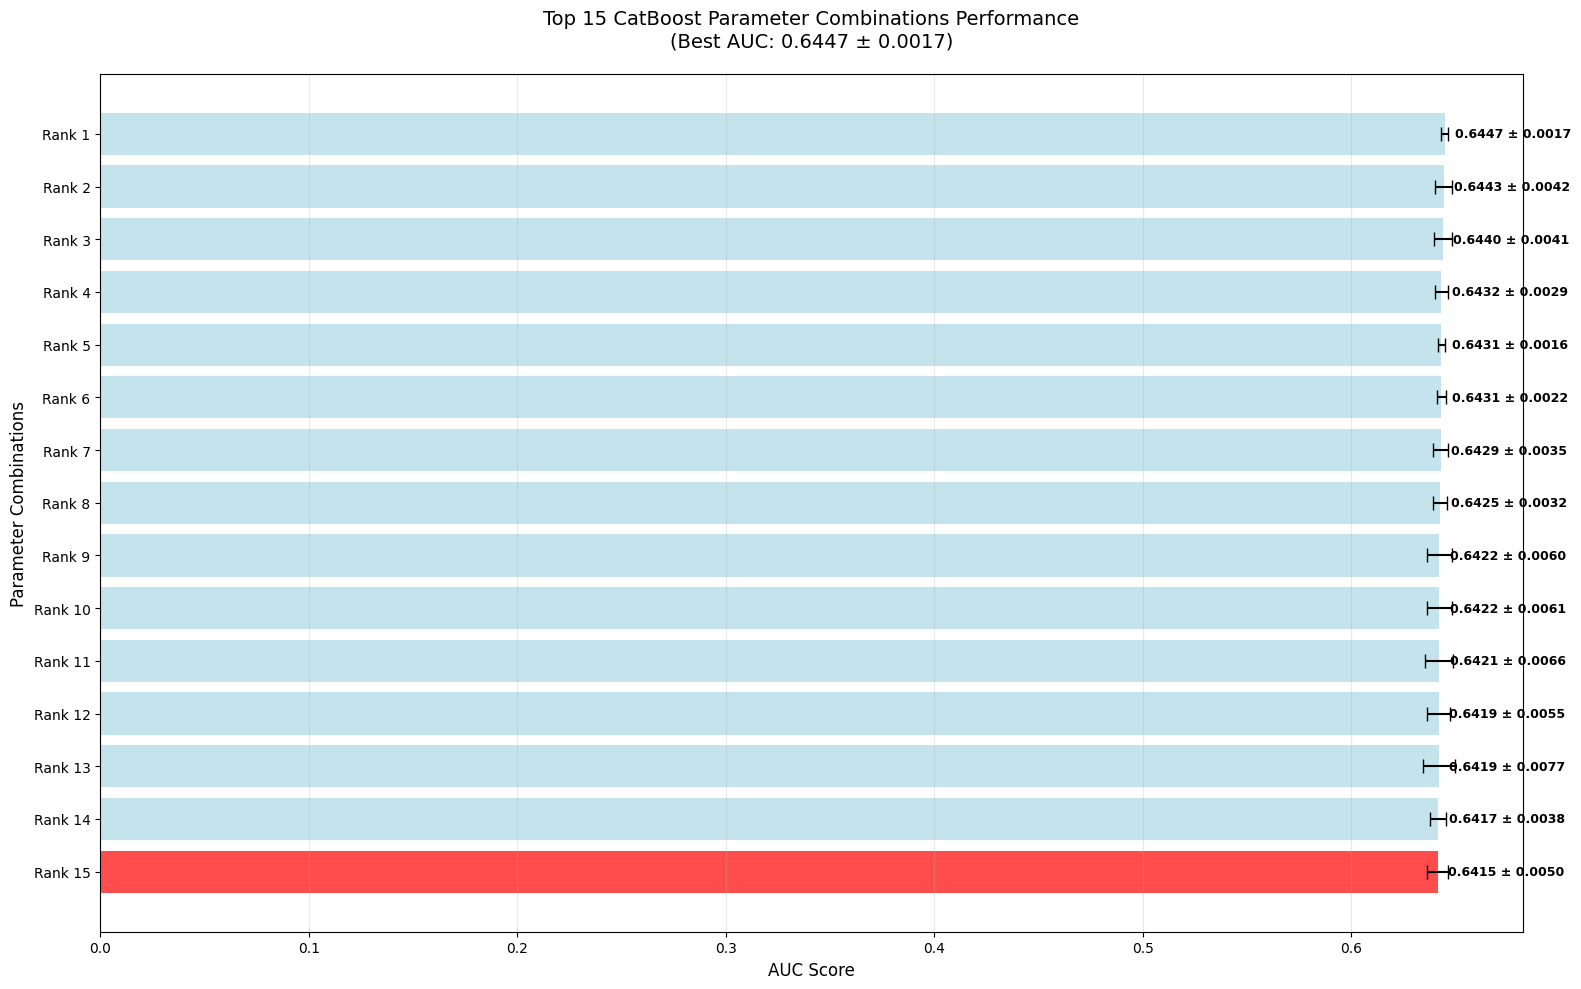

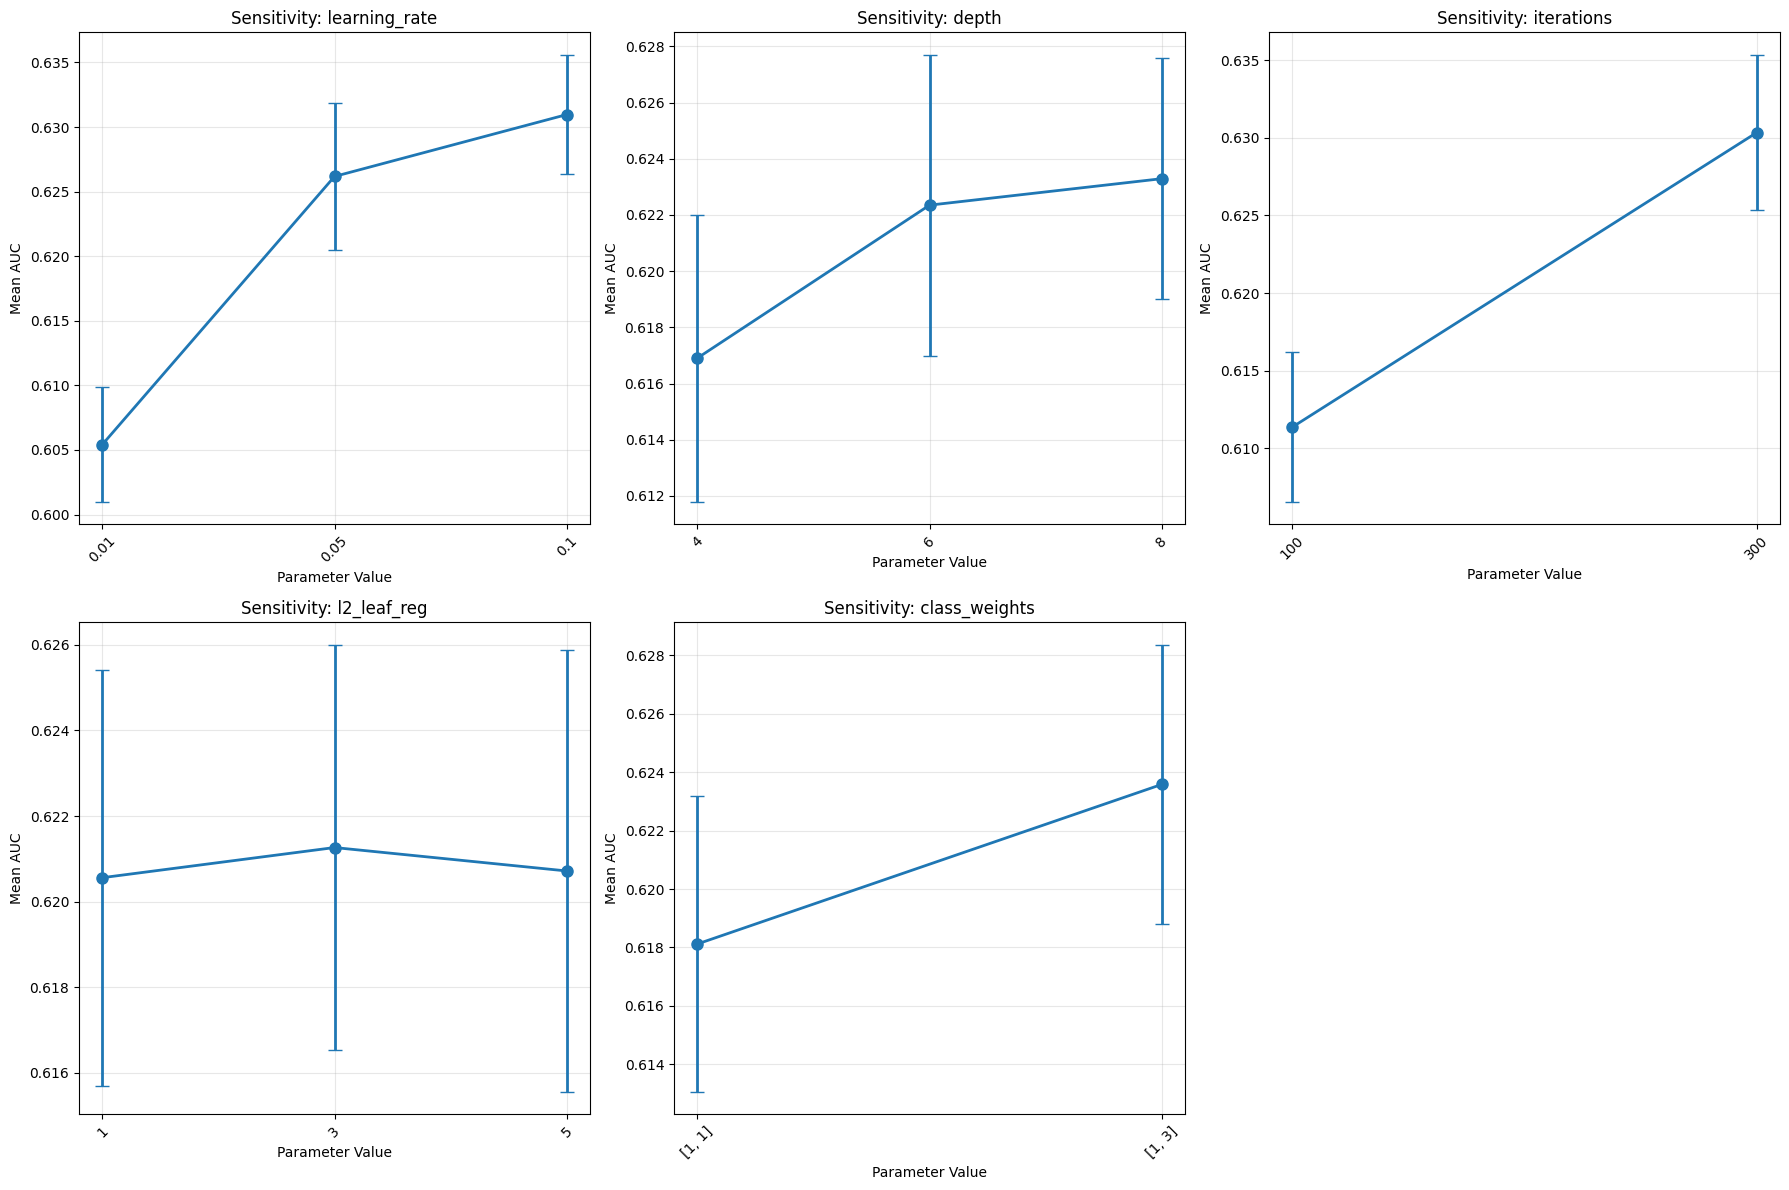

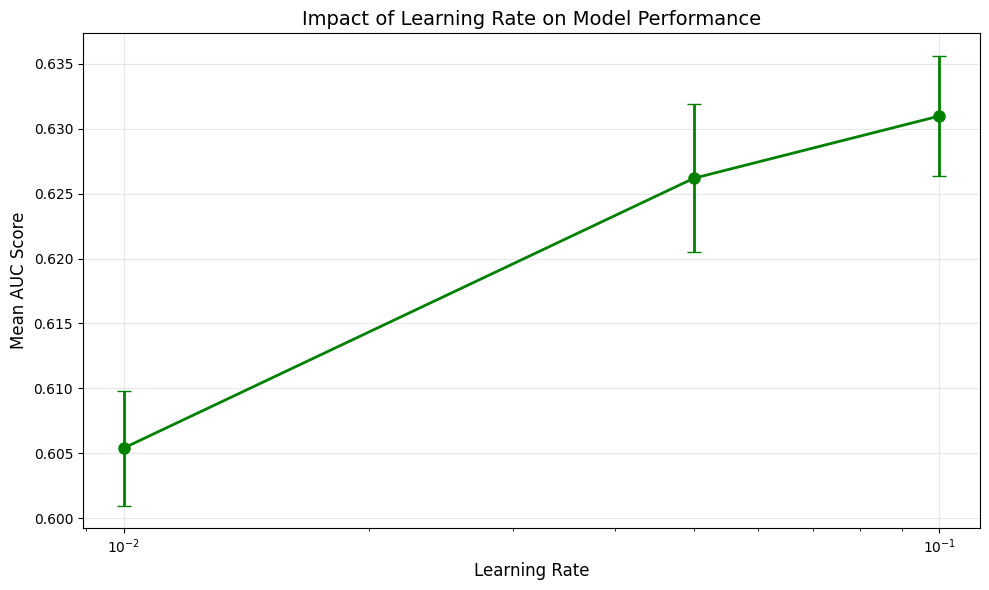

BEST PARAMETER COMBINATION DETAILS
AUC Score: 0.6447 ± 0.0017

Parameter Values:
  class_weights: [1, 3]
  depth: 6
  iterations: 300
  l2_leaf_reg: 5
  learning_rate: 0.1

Improvement over average: +0.0239 (3.8%)

Final Test AUC: 0.6620
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.61      0.71      7735
           1       0.33      0.60      0.42      2442

    accuracy                           0.61     10177
   macro avg       0.58      0.61      0.57     10177
weighted avg       0.71      0.61      0.64     10177



In [5]:
from sklearn.model_selection import GridSearchCV
import numpy as np

model = CatBoostClassifier(
    silent=True,
    random_state=42,
    eval_metric='AUC',
    cat_features=cat_features
)

param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [4, 6, 8],
    'iterations': [100, 300],
    'l2_leaf_reg': [1, 3, 5],
    'class_weights': [[1, 1], [1, 3]]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    verbose=100,
    n_jobs=1
)

grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)

print("\n" + "="*60)
print("CATBOOST HYPERPARAMETER TUNING ANALYSIS")
print("="*60)

best_idx = plot_catboost_tuning_results(grid_search)
plot_parameter_sensitivity(grid_search)
plot_learning_rate_impact(grid_search)

# Evaluate
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]
fpr_tuned, tpr_tuned, thresholds = roc_curve(y_test, y_prob)
auc_tuned = roc_auc_score(y_test, y_prob)
report = classification_report(y_test, y_pred)

print(f"\nFinal Test AUC: {auc_tuned:.4f}")
print("Classification Report:\n", report)

### Feature Engineering

#### FE

In [ ]:
def create_catboost_specific_features(train_data, test_data):

    # Numeric feature
    train_data['Age_Range'] = pd.cut(train_data['Upper_Age'], bins=5, labels=False)
    test_data['Age_Range'] = pd.cut(test_data['Upper_Age'], bins=5, labels=False)

    train_data['Premium_to_Age_Ratio'] = train_data['Reco_Policy_Premium'] / (train_data['Upper_Age'] + 1)
    test_data['Premium_to_Age_Ratio'] = test_data['Reco_Policy_Premium'] / (test_data['Upper_Age'] + 1)

    # Categorical feature
    categorical_cols = [
        'Reco_Policy_Cat', 'City_Code', 'Region_Code',
        'Reco_Insurance_Type', 'Accomodation_Type',
        'Health_Indicator', 'Holding_Policy_Type', 'Is_Spouse'
    ]

    for col in categorical_cols:
        if col in train_data.columns:
            freq_encoding = train_data[col].value_counts(normalize=True)
            train_data[f'{col}_freq'] = train_data[col].map(freq_encoding)
            test_data[f'{col}_freq'] = test_data[col].map(freq_encoding)
            test_data[f'{col}_freq'] = test_data[f'{col}_freq'].fillna(0)

    # Label encode
    for col in ['Reco_Policy_Cat', 'City_Code']:
        if col in train_data.columns:
            target_mean = train_data.groupby(col)['Response'].mean()
            train_data[f'{col}_target_enc'] = train_data[col].map(target_mean)
            test_data[f'{col}_target_enc'] = test_data[col].map(target_mean)
            test_data[f'{col}_target_enc'] = test_data[f'{col}_target_enc'].fillna(train_data['Response'].mean())

    # Interaction
    train_data['Age_Premium_Interaction'] = train_data['Upper_Age'] * train_data['Reco_Policy_Premium']
    test_data['Age_Premium_Interaction'] = test_data['Upper_Age'] * test_data['Reco_Policy_Premium']

    train_data['Age_Duration_Interaction'] = train_data['Upper_Age'] * train_data['Holding_Policy_Duration']
    test_data['Age_Duration_Interaction'] = test_data['Upper_Age'] * test_data['Holding_Policy_Duration']

    train_data['Duration_Group'] = pd.cut(train_data['Holding_Policy_Duration'], bins=5, labels=False)
    test_data['Duration_Group'] = pd.cut(test_data['Holding_Policy_Duration'], bins=5, labels=False)

    return train_data, test_data

In [ ]:
def prepare_features_for_catboost_enhanced(X_train, y_train, X_test):
    train_data = X_train.copy()
    test_data = X_test.copy()
    train_data['Response'] = y_train.values

    train_data, test_data = create_catboost_specific_features(train_data, test_data)

    X_train_final = train_data.drop(columns=['Response'])
    X_test_final = test_data

    categorical_cols = [
        'Reco_Policy_Cat', 'City_Code', 'Region_Code',
        'Reco_Insurance_Type', 'Accomodation_Type',
        'Health_Indicator', 'Holding_Policy_Type', 'Is_Spouse'
    ]

    categorical_features_indices = [
        i for i, col in enumerate(X_train_final.columns)
        if col in categorical_cols and X_train_final[col].dtype == 'object'
    ]

    print(f"Number of category features: {len(categorical_features_indices)}")
    print(f"Total number of features: {X_train_final.shape[1]}")
    print(f"Train shape: {X_train_final.shape}")
    print(f"Test shape: {X_test_final.shape}")

    return X_train_final, X_test_final, train_data['Response'], categorical_features_indices

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score, f1_score, roc_curve
from catboost import CatBoostClassifier
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

def train_catboost_with_features(X_train, y_train, X_test, y_test, cat_features):
    print("=" * 30, "CatBoost + Feature Engineering", "=" * 30)

    model = CatBoostClassifier(
        random_seed=42,
        verbose=100,
        cat_features=cat_features,
        auto_class_weights='Balanced',
        task_type='CPU',
        iterations=300,
        learning_rate=0.1,
        depth=6
    )

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    print(f"ROC AUC: {roc_auc:.4f}")
    print("Classification report:")
    print(classification_report(y_test, y_pred))

    return {
        'model': model,
        'fpr': fpr,
        'tpr': tpr,
        'roc_auc': roc_auc,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }

if __name__ == "__main__":

    data = pd.read_csv("clean.csv")
    X = data.drop(columns=["Response", "ID", "Unnamed: 0"])
    y = data["Response"]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    X_train_enhanced, X_test_enhanced, y_train_enhanced, cat_features = \
        prepare_features_for_catboost_enhanced(X_train, y_train, X_test)

    result = train_catboost_with_features(
        X_train_enhanced, y_train_enhanced, X_test_enhanced, y_test, cat_features
    )

    print(f"Test set ROC AUC: {result['roc_auc']:.4f}")
    fpr_fe=result['fpr']
    tpr_fe=result['tpr']
    auc_fe=result['roc_auc']

Number of category features: 4
Total number of features: 27
Train shape: (40705, 27)
Test shape: (10177, 27)
============================== CatBoost + Feature Engineering ==============================
0:	learn: 0.6845090	total: 63.9ms	remaining: 19.1s
100:	learn: 0.6299971	total: 6.49s	remaining: 12.8s
200:	learn: 0.6035205	total: 13.2s	remaining: 6.51s
299:	learn: 0.5837125	total: 19.8s	remaining: 0us
ROC AUC: 0.6732
Classification report:
              precision    recall  f1-score   support

           0       0.84      0.58      0.69      7735
           1       0.33      0.66      0.44      2442

    accuracy                           0.60     10177
   macro avg       0.59      0.62      0.57     10177
weighted avg       0.72      0.60      0.63     10177

Test set ROC AUC: 0.6732


#### FE + Tuned

In [7]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score, f1_score
from catboost import CatBoostClassifier, Pool
import warnings
warnings.filterwarnings('ignore')

def tune_catboost_enhanced(X_train, y_train, cat_features, scoring='roc_auc'):

    param_grid = {
        'learning_rate': [0.01, 0.05, 0.1],
        'depth': [4, 6, 8],
        'iterations': [100, 300],
        'l2_leaf_reg': [1, 3, 5],
        'class_weights': [[1, 1], [1, 3]]
    }

    grid_search = GridSearchCV(
        estimator=CatBoostClassifier(
            random_seed=42,
            verbose=100,
            cat_features=cat_features,
            # auto_class_weights='Balanced',
            task_type='CPU',
            early_stopping_rounds=50
        ),
        param_grid=param_grid,
        scoring=scoring,
        cv=3,
        n_jobs=1,
        verbose=100
    )

    grid_search.fit(X_train, y_train)

    print(f"Best params: {grid_search.best_params_}")
    print(f"Best cross validation {scoring} score: {grid_search.best_score_:.4f}")

    return grid_search.best_estimator_, grid_search.best_params_, grid_search.best_score_

if __name__ == "__main__":

    data = pd.read_csv("clean.csv")
    X = data.drop(columns=["Response", "ID", "Unnamed: 0"])
    y = data["Response"]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    X_train_enhanced, X_test_enhanced, y_train_enhanced, cat_features = \
        prepare_features_for_catboost_enhanced(X_train, y_train, X_test)

    best_model, best_params, best_score = tune_catboost_enhanced(
        X_train_enhanced, y_train_enhanced, cat_features
    )


    y_pred_proba = best_model.predict_proba(X_test_enhanced)[:, 1]
    fpr_fe_tuned, tpr_fe_tuned, _ = roc_curve(y_test, y_pred_proba)
    auc_fe_tuned = roc_auc_score(y_test, y_pred_proba)
    print(f"Final AUC: {auc_fe_tuned:.4f}")

Number of category features: 4
Total number of features: 27
Train shape: (40705, 27)
Test shape: (10177, 27)
Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV 1/3; 1/108] START class_weights=[1, 1], depth=4, iterations=100, l2_leaf_reg=1, learning_rate=0.01
0:	learn: 0.6898655	total: 43ms	remaining: 4.26s
99:	learn: 0.5510665	total: 4.5s	remaining: 0us
[CV 1/3; 1/108] END class_weights=[1, 1], depth=4, iterations=100, l2_leaf_reg=1, learning_rate=0.01;, score=0.630 total time=   4.5s
[CV 2/3; 1/108] START class_weights=[1, 1], depth=4, iterations=100, l2_leaf_reg=1, learning_rate=0.01
0:	learn: 0.6898180	total: 41.3ms	remaining: 4.09s
99:	learn: 0.5505162	total: 4.57s	remaining: 0us
[CV 2/3; 1/108] END class_weights=[1, 1], depth=4, iterations=100, l2_leaf_reg=1, learning_rate=0.01;, score=0.622 total time=   4.6s
[CV 3/3; 1/108] START class_weights=[1, 1], depth=4, iterations=100, l2_leaf_reg=1, learning_rate=0.01
0:	learn: 0.6898440	total: 40.7ms	remaining: 4.03s
99:

## ROC

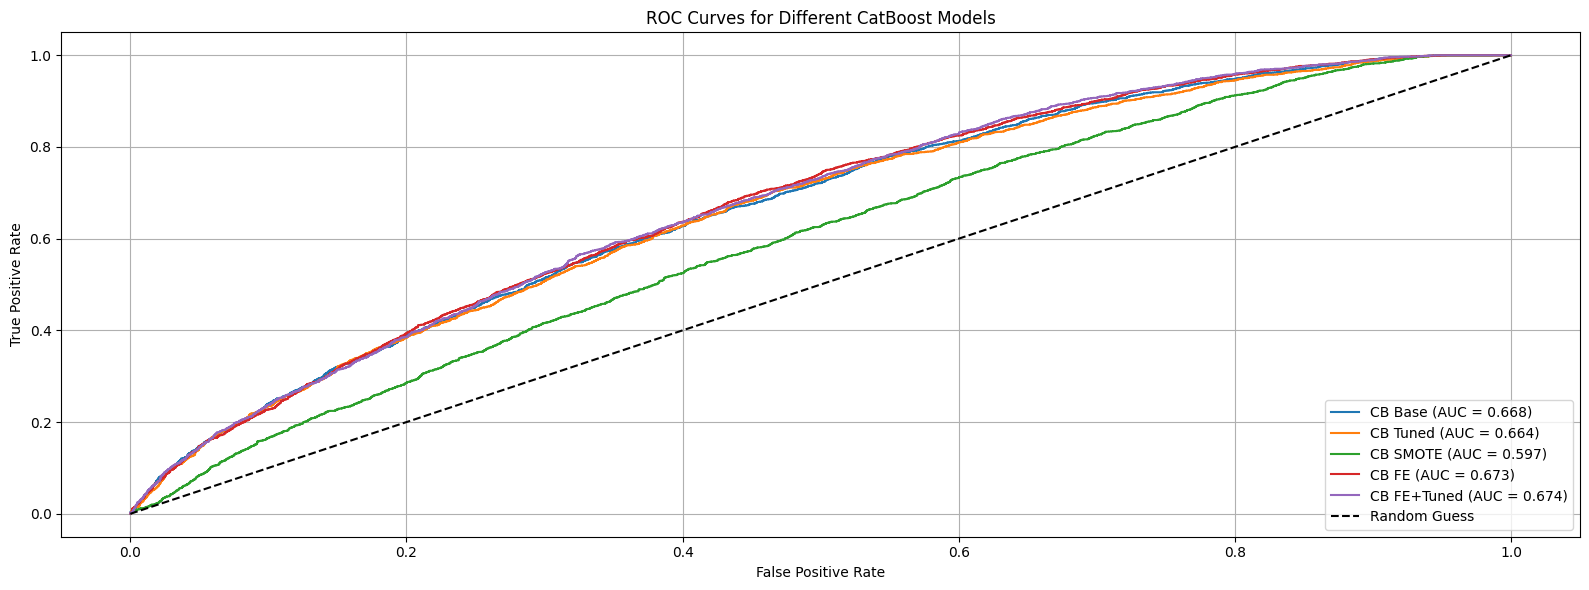

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 6))

plt.plot(fpr_base,  tpr_base,  label=f"CB Base (AUC = {auc_base:.3f})")
plt.plot(fpr_tuned,  tpr_tuned,  label=f"CB Tuned (AUC = {auc_tuned:.3f})")
plt.plot(fpr_sm,  tpr_sm,  label=f"CB SMOTE (AUC = {auc_sm:.3f})")
plt.plot(fpr_fe,  tpr_fe,  label=f"CB FE (AUC = {auc_fe:.3f})")
plt.plot(fpr_fe_tuned,  tpr_fe_tuned,  label=f"CB FE+Tuned (AUC = {auc_fe_tuned:.3f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Different CatBoost Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()